# Artificial Neural Networks and Deep Learning - Assignment 2



## 📃 Task



In this assignment, you will receive 64x128 grayscale real images from Mars terrain. Pixels in these images are categorized into five classes, each representing a particular type of terrain. This is a semantic segmentation problem, so your goal is to assign the correct class label to each mask pixel.

In [1]:
is_kaggle = True
is_colab = False
manual_analysis = False  # DO NOT CHANGE TO THIS IF YOU DO NOT WANT TO FILL YOUR DRIVE WITH IMAGES

In [2]:
# Name of the model using the date
from datetime import datetime

timestep_str = datetime.now().strftime("%y%m%d_%H%M%S")
model_filename = f"model_{timestep_str}"
print(model_filename)

model_241211_144036


## 🌐 Connect Colab to Google Drive

In [3]:
if is_colab:
    from google.colab import drive

    drive.mount("/gdrive")
    %cd /gdrive/My Drive/[2024-2025] AN2DL/Homework 2

## ⚙️ Import Libraries

In [4]:
import os
from datetime import datetime

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

import matplotlib.pyplot as plt
%matplotlib inline

seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.16.1
Keras version: 3.3.3
GPU devices: 2


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

colors = ['#440154', '#3b528b', '#21918c', '#5ec962', '#fde725']
cmap = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm(np.arange(6), cmap.N)

class_names = ["Background", "Soil", "Bedrock", "Sand", "Big Rock"]

## ⏳ Load the Data

In [6]:
if is_colab:
    data = np.load("mars_for_students.npz")
elif is_kaggle:
    data = np.load("/kaggle/input/mars-rocks/mars_for_students.npz")  # change this with the actual kaggle path
else:
    data = np.load("../mars_for_students.npz")

training_set = data["training_set"] # ['training_set', 'test_set']
X_train = training_set[:, 0]
y_train = training_set[:, 1]

X_test = data["test_set"]

print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")

Training X shape: (2615, 64, 128)
Training y shape: (2615, 64, 128)
Test X shape: (10022, 64, 128)


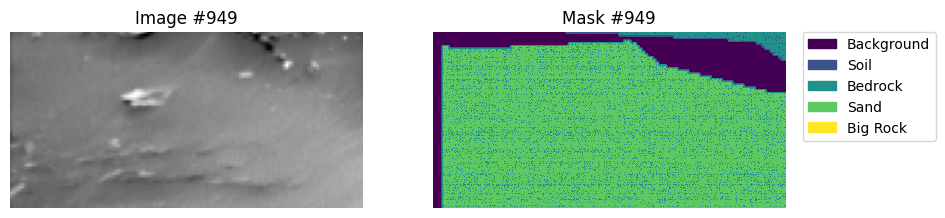

In [7]:
import random
import matplotlib.patches as mpatches

index = random.randint(0, X_train.shape[0])

# Visualize images and masks
def visualize_sample(image, mask, index):
    plt.figure(figsize=(10, 5))

    # image
    plt.subplot(1, 2, 1)
    plt.title(f"Image #{index}")
    plt.imshow(image, cmap='gray')
    plt.axis('off')

    # mask
    plt.subplot(1, 2, 2)
    plt.title(f"Mask #{index}")
    plt.imshow(mask, cmap=cmap, norm=norm)
    plt.axis('off')

    # Create custom legend
    colors = cmap.colors
    patches = [mpatches.Patch(color=colors[i], label=class_names[i]) for i in range(5)]
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    plt.show()

# Visualize an example from the dataset
visualize_sample(X_train[index], y_train[index], index=index)

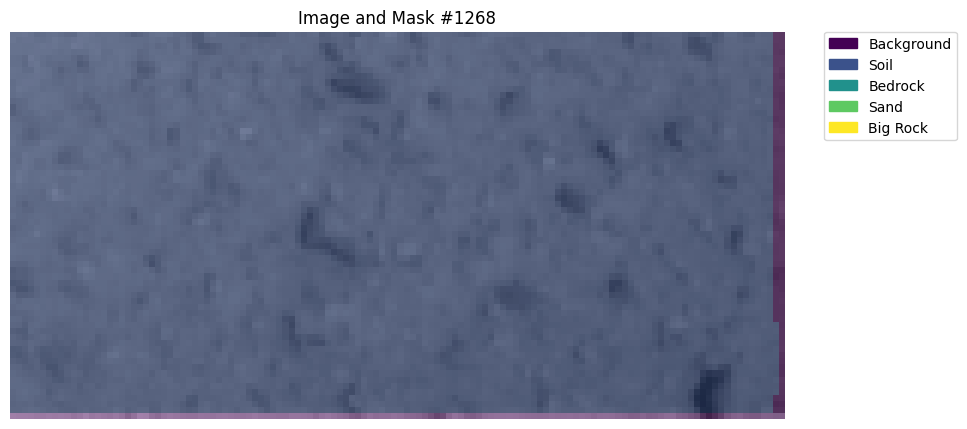

In [8]:
def display_image_and_mask(image, mask, index):
    plt.figure(figsize=(10, 10))

    # Display image
    plt.subplot(1, 1, 1)
    plt.title(f"Image and Mask #{index}")
    plt.imshow(image, cmap='gray')
    plt.imshow(mask, cmap=cmap, norm=norm, alpha=0.5)  # Add mask with transparency
    plt.axis('off')

    # Create custom legend
    colors = cmap.colors
    patches = [mpatches.Patch(color=colors[i], label=class_names[i]) for i in range(5)]
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    plt.show()

# Display an example from the dataset
index = random.randint(0, X_train.shape[0])
display_image_and_mask(X_train[index], y_train[index], index=index)

### 🧹 Data cleaning

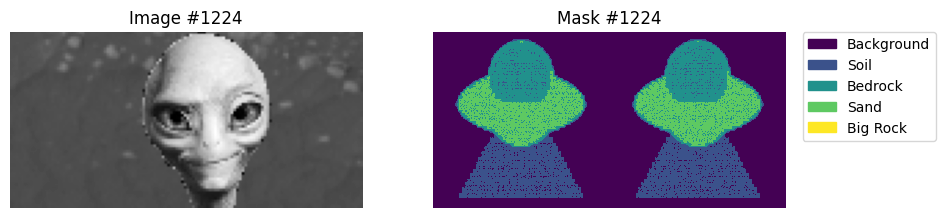

In [9]:
# Visualize an example from the dataset
index = 1224
visualize_sample(X_train[index], y_train[index], index=index)

In [10]:
import numpy as np
import matplotlib.pyplot as plt

"""
Remove samples from the dataset where the mask matches the alien_mask.

Args:
    X (numpy array): Array of images (shape: [n_samples, height, width]).
    Y (numpy array): Array of masks (shape: [n_samples, height, width]).
    alien_mask (numpy array): The mask to identify alien samples.

Returns:
    X_cleaned, Y_cleaned: Cleaned arrays without alien samples.
"""

def remove_alien_samples(X, Y, alien_mask):
    # Find indices where masks do NOT match the alien mask
    indices_to_keep = [i for i in range(Y.shape[0]) if not np.array_equal(Y[i], alien_mask)]

    # Filter the dataset to keep only valid samples
    X_cleaned = X[indices_to_keep]
    Y_cleaned = Y[indices_to_keep]

    return X_cleaned, Y_cleaned

# Load the alien mask image (the first one is the number 62 of the dataset)
alien_mask = y_train[62]

# remove alien samples from the dataset
X_train_cleaned, y_train_cleaned = remove_alien_samples(X_train, y_train, alien_mask)

# print the shapes of the original and cleaned datasets
print(f"Original shape: {X_train.shape}, {y_train.shape}")
print(f"Cleaned shape: {X_train_cleaned.shape}, {y_train_cleaned.shape}")

# Update the training set with the cleaned data
X_train = X_train_cleaned
y_train = y_train_cleaned

Original shape: (2615, 64, 128), (2615, 64, 128)
Cleaned shape: (2505, 64, 128), (2505, 64, 128)


### 🔍 Inspect the Dataset

In [11]:
# save valuable information about the dataset
dataset_info = {
    "training_set_shape": X_train.shape,
    "test_set_shape": X_test.shape,
    "image_dimensions": X_train.shape[1:],
    "mask_dimensions": y_train.shape[1:],
    "number_of_classes": len(np.unique(y_train)),
    "segmentation_classes": np.unique(y_train),
}

In [12]:
# Display information about the dataset
print(f"Dataset keys: {data.files}")
print(f"Training set: {dataset_info['training_set_shape']}")
print(f"Test set: {dataset_info['test_set_shape']}")
print(f"Image dimensions (train): {dataset_info['image_dimensions']}")
print(f"Mask dimensions (train): {dataset_info['mask_dimensions']}")
print(f"Number of classes: {dataset_info['number_of_classes']}")
print(f"Segmentation classes: {dataset_info['segmentation_classes']}")

Dataset keys: ['training_set', 'test_set']
Training set: (2505, 64, 128)
Test set: (10022, 64, 128)
Image dimensions (train): (64, 128)
Mask dimensions (train): (64, 128)
Number of classes: 5
Segmentation classes: [0. 1. 2. 3. 4.]


Class distribution:
Class 0 (Background): 4988826 pixel (24.31%)
Class 1 (Soil): 6957538 pixel (33.90%)
Class 2 (Bedrock): 4776810 pixel (23.28%)
Class 3 (Sand): 3770823 pixel (18.38%)
Class 4 (Big Rock): 26963 pixel (0.13%)


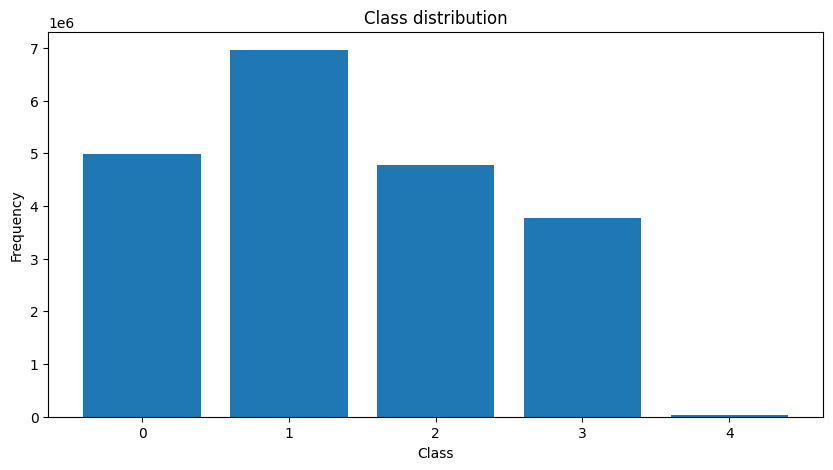

In [13]:
# Visualize the distribution of classes in the dataset
def display_class_distribution(y_train=y_train):
    unique, counts = np.unique(y_train, return_counts=True)
    class_distribution = dict(zip(unique, counts))

    print("Class distribution:")

    for class_label, count in class_distribution.items():
        print(f"Class {int(class_label)} ({class_names[int(class_label)]}): {count} pixel ({count / np.sum(counts) * 100:.2f}%)")

    # Visualize the class distribution
    plt.figure(figsize=(10, 5))
    plt.bar(class_distribution.keys(), class_distribution.values())
    plt.xlabel("Class")
    plt.ylabel("Frequency")
    plt.title("Class distribution")
    plt.show()

display_class_distribution()

## 🧹 Data Preprocessing

### 📂 Data Splitting

In [14]:
# # Split the training set into training and validation sets (80% training, 20% validation)
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=seed)

# Display the shapes of the training and validation sets
print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")

Training set: (2004, 64, 128), (2004, 64, 128)
Validation set: (501, 64, 128), (501, 64, 128)


### 📊 Data Normalization

In [15]:
# Add color channel and rescale pixels between 0 and 1
X_train = X_train[..., np.newaxis] / 255.0
X_val = X_val[..., np.newaxis] / 255.0
X_test = X_test[..., np.newaxis] / 255.0

# print shape
print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

Training set: (2004, 64, 128, 1)
Validation set: (501, 64, 128, 1)
Test set: (10022, 64, 128, 1)


### 📚 Data Augmentation

In [16]:
!pip install -q keras_cv

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [17]:
print("Image shape:", X_train.shape[1:])
print("Mask shape:", y_train.shape[1:])

Image shape: (64, 128, 1)
Mask shape: (64, 128)


In [18]:
import keras_cv

# Augmentation pipeline for images and masks
# This augmentation will include transformations that do not change the class of the pixel on the mask
def create_segmentation_augmentation_pipeline(segmentation_classes=dataset_info['number_of_classes'], seed=seed):
    # Define augmentation layers for segmentation

    layers = [
        # Geometric transformations
        keras_cv.layers.RandomFlip(mode='horizontal_and_vertical', seed=seed),
        keras_cv.layers.RandomTranslation(
            height_factor=(-0.5, 0.5),  # Limited shift
            width_factor=(-0.5, 0.5),
            seed=seed,
            fill_mode='nearest'
        ),

        keras_cv.layers.RandomRotation(
            factor=(-0.1, 0.1),  # Slight rotations
            seed=seed,
            fill_mode='nearest',
            segmentation_classes=segmentation_classes
        ),

        keras_cv.layers.RandomCrop(
            height = dataset_info['image_dimensions'][0],
            width = dataset_info['image_dimensions'][1],
            seed=seed,
        ),

        keras_cv.layers.RandomZoom(
            height_factor=(-0.5, 0.5),  # Limited zoom
            width_factor=(-0.5, 0.5),
            seed=seed,
            fill_mode='nearest',
        )
    ]

    # Create the pipeline with moderate application rate
    pipeline = keras_cv.layers.RandomAugmentationPipeline(
        layers=layers,
        augmentations_per_image=2,  # Apply 2 random augmentations per image
        rate=1,  # 100% chance of applying augmentation to each image
        seed=seed
    )

    return pipeline

image_mask_augmentation_pipeline = create_segmentation_augmentation_pipeline(seed = seed)

In [19]:
def augment_segmentation_data(images, masks, pipeline, segmentation_classes, epoch):
    if epoch % 2 == 0:
        # Concatenate image and mask
        images = tf.cast(images, tf.float32)    # Ensure images are float32
        mask = tf.cast(masks, tf.float32)       # Ensure mask is float32
        combined = tf.concat([images, tf.expand_dims(mask, axis=-1)], axis=-1)

        # Apply augmentation
        augmented = pipeline(combined)

        # Separate augmented images and masks
        augmented_images = augmented[..., :images.shape[-1]]
        augmented_masks = tf.cast(tf.squeeze(augmented[..., images.shape[-1]:], axis=-1), tf.int32) # Ensure mask is int32 again

        return augmented_images, augmented_masks
    else:
        return images, masks

In [20]:
def visualize_segmentation_augmentations(images, masks, pipeline, epoch, segmentation_classes=dataset_info['number_of_classes'], num_samples=2):
    # Generate random indices
    random_indices = np.random.choice(len(images), size=num_samples, replace=False)

    # Get original images and masks
    original_images = images[random_indices]
    original_masks = masks[random_indices]

    # Prepare figures
    fig, axes = plt.subplots(2, 2*num_samples)
    fig.set_figheight(6)
    fig.set_figwidth(12)

    # Augment samples
    for i, (image, mask) in enumerate(zip(original_images, original_masks)):
        # Apply augmentation
        augmented_image, augmented_mask = augment_segmentation_data(
            tf.expand_dims(image, 0),
            tf.expand_dims(mask, 0),
            pipeline=pipeline,
            segmentation_classes=segmentation_classes,
            epoch = 0
        )

        # Squeeze dimensions
        augmented_image = augmented_image.numpy().squeeze()
        augmented_mask = augmented_mask.numpy().squeeze()

        # Ensure the images and masks have the correct shape
        if len(image.shape) == 2:
            image = image[..., np.newaxis]

        if len(mask.shape) == 2:
            mask = mask[..., np.newaxis]

        if len(augmented_image.shape) == 2:
            augmented_image = augmented_image[..., np.newaxis]

        if len(augmented_mask.shape) == 2:
            augmented_mask = augmented_mask[..., np.newaxis]

        # Plot original image
        axes[0, 2*i].imshow(image[..., 0], cmap='gray')
        axes[0, 2*i].set_title(f'Original Image {random_indices[i]}')
        axes[0, 2*i].axis('off')

        # Plot original mask
        axes[0, 2*i+1].imshow(mask[..., 0], cmap='viridis')
        axes[0, 2*i+1].set_title(f'Original Mask {random_indices[i]}')
        axes[0, 2*i+1].axis('off')

        # Plot augmented image
        axes[1, 2*i].imshow(augmented_image[..., 0], cmap='gray')
        axes[1, 2*i].set_title(f'Augmented Image {random_indices[i]}')
        axes[1, 2*i].axis('off')

        # Plot augmented mask
        axes[1, 2*i+1].imshow(augmented_mask[..., 0], cmap='viridis')
        axes[1, 2*i+1].set_title(f'Augmented Mask {random_indices[i]}')
        axes[1, 2*i+1].axis('off')

        # display image information (shape, min, max, dtype)
        print(f"Image {random_indices[i]} - Original: {image.shape}, {image.min()}, {image.max()}, {image.dtype}")
        print(f"Image {random_indices[i]} - Augmented: {augmented_image.shape}, {augmented_image.min()}, {augmented_image.max()}, {augmented_image.dtype}")

    # Create custom legend
    colors = [plt.cm.viridis(i / 4) for i in range(5)]
    patches = [mpatches.Patch(color=colors[i], label=class_names[i]) for i in range(5)]
    fig.legend(handles=patches, loc='upper center', bbox_to_anchor=(0.5, 1.02), ncol=5)

    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.tight_layout(h_pad=0.5, w_pad=0.5)
    plt.show()

### ⚖️ Data Balancing

In [21]:
def remove_single_class_samples(X_train, y_train):
  total_removed = 0

  for i in range(dataset_info["number_of_classes"]):
      mask_indeces_with_single_class = [j for j in range(y_train.shape[0]) if np.all(y_train[j] == i)]

      print(f"Class {i} ({class_names[i]}): {len(mask_indeces_with_single_class)} samples")

      total_removed += len(mask_indeces_with_single_class)

      # remove samples with only one class
      if len(mask_indeces_with_single_class) > 0:
          X_train = np.delete(X_train, mask_indeces_with_single_class, axis=0)
          y_train = np.delete(y_train, mask_indeces_with_single_class, axis=0)

  # Display the shapes of the training and validation sets
  print(f"Training set: {X_train.shape}, {y_train.shape}")
  print(f"Removed samples: {total_removed}")

remove_single_class_samples(X_train, y_train)

Class 0 (Background): 4 samples
Class 1 (Soil): 182 samples
Class 2 (Bedrock): 70 samples
Class 3 (Sand): 73 samples
Class 4 (Big Rock): 0 samples
Training set: (1675, 64, 128, 1), (1675, 64, 128)
Removed samples: 329


Class distribution:
Class 0 (Background): 3979893 pixel (24.24%)
Class 1 (Soil): 5532162 pixel (33.70%)
Class 2 (Bedrock): 3924593 pixel (23.91%)
Class 3 (Sand): 2958791 pixel (18.02%)
Class 4 (Big Rock): 21329 pixel (0.13%)


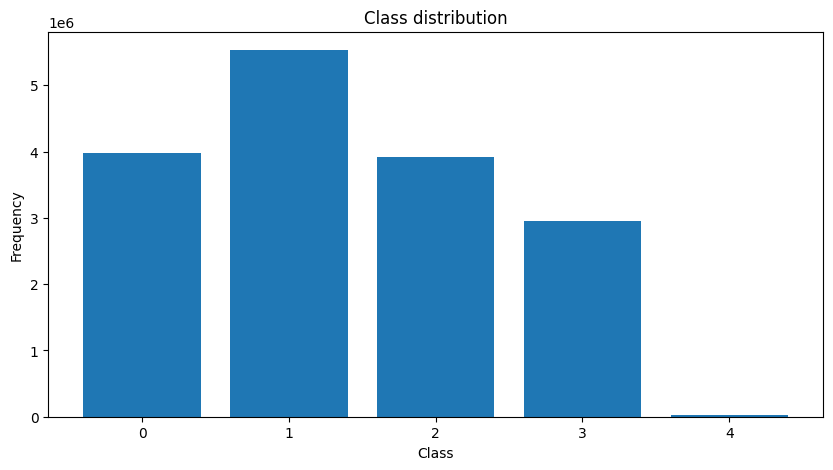

In [22]:
# Visualize the distribution of classes in the training set
display_class_distribution(y_train)

In [23]:
unique, counts = np.unique(y_train, return_counts=True)
class_distribution = dict(zip(unique, counts))

In [24]:
import numpy as np
import cv2

def balance_classes(X_train, y_train, class_distribution_train):
    """
    Balance dataset by finding and cropping regions of specific classes
    """
    # Find target class distribution (mean of all classes)
    mean_count = np.mean(list(class_distribution_train.values()))
    max_count = max(class_distribution_train.values())

    # Ensure X_train and y_train have consistent shapes
    if X_train.ndim == 3:
        X_train = X_train[..., np.newaxis]
    if y_train.ndim == 3:
        y_train = y_train[..., np.newaxis]

    # Lists to store new samples
    new_X_train = []
    new_y_train = []

    total_added = 0

    for classe, current_count in class_distribution_train.items():
        if classe == 0:  # Skip background
            continue

        # Determine multiplier to balance class
        if classe == 3:
            multiplier = int(mean_count) // (current_count)
        else:
            multiplier = int(mean_count) // (7 * current_count)
        print(f"Multiplier for class {classe}: {int(mean_count)} // {current_count} = {multiplier}")

        # Find images containing the current class
        class_indices = [i for i in range(len(y_train))
                         if classe in np.unique(y_train[i, :, :, 0])]

        class_added = 0

        for idx in class_indices:
            # Find bounding box for the specific class
            mask = y_train[idx, :, :, 0]
            class_mask = (mask == classe).astype(np.uint8)

            # Find contours of the class region
            contours, _ = cv2.findContours(class_mask,
                                           cv2.RETR_EXTERNAL,
                                           cv2.CHAIN_APPROX_SIMPLE)

            if not contours:
                continue

            # Get bounding rectangle of the class
            x, y, w, h = cv2.boundingRect(contours[0])

            # Extend bounding box with some margin
            margin = max(w, h) // 4
            x = max(0, x - margin)
            y = max(0, y - margin)
            w = min(X_train[idx].shape[1] - x, w + 2 * margin)
            h = min(X_train[idx].shape[0] - y, h + 2 * margin)

            # Crop image and mask
            cropped_img = X_train[idx][y:y + h, x:x + w, :]
            cropped_mask = y_train[idx][y:y + h, x:x + w, :]

            # Resize to (64, 128)
            resized_img = cv2.resize(cropped_img, (128, 64),
                                     interpolation=cv2.INTER_AREA)
            resized_mask = cv2.resize(cropped_mask, (128, 64),
                                      interpolation=cv2.INTER_NEAREST)

            # Duplicate samples to balance class
            for _ in range(multiplier):
                new_X_train.append(resized_img)
                new_y_train.append(resized_mask)
                class_added += 1

        print(f"Added {class_added} elements for class {classe}")
        total_added += class_added

    print(f"Total elements added: {total_added}")

    # Convert to numpy arrays with consistent shapes
    new_X_train = np.array(new_X_train)
    new_y_train = np.array(new_y_train)

    return new_X_train, new_y_train

# Balance the dataset
X_train_balanced, y_train_balanced = balance_classes(X_train, y_train, class_distribution)


Multiplier for class 1.0: 3283353 // 5532162 = 0
Added 0 elements for class 1.0
Multiplier for class 2.0: 3283353 // 3924593 = 0
Added 0 elements for class 2.0
Multiplier for class 3.0: 3283353 // 2958791 = 1
Added 688 elements for class 3.0
Multiplier for class 4.0: 3283353 // 21329 = 21
Added 1176 elements for class 4.0
Total elements added: 1864


In [25]:
# Combine the original and balanced datasets
X_train_combined = np.concatenate([X_train, X_train_balanced[..., np.newaxis]], axis=0) # add a new axis to X_train_balanced
y_train_combined = np.concatenate([y_train, y_train_balanced], axis=0)

In [26]:
remove_single_class_samples(X_train_combined, y_train_combined)

Class 0 (Background): 4 samples
Class 1 (Soil): 182 samples
Class 2 (Bedrock): 70 samples
Class 3 (Sand): 165 samples
Class 4 (Big Rock): 168 samples
Training set: (3279, 64, 128, 1), (3279, 64, 128)
Removed samples: 589


Combined training set: (3868, 64, 128, 1), (3868, 64, 128)
Class distribution:
Class 0 (Background): 9971051 pixel (31.47%)
Class 1 (Soil): 6157270 pixel (19.43%)
Class 2 (Bedrock): 4859880 pixel (15.34%)
Class 3 (Sand): 7401349 pixel (23.36%)
Class 4 (Big Rock): 3297106 pixel (10.41%)


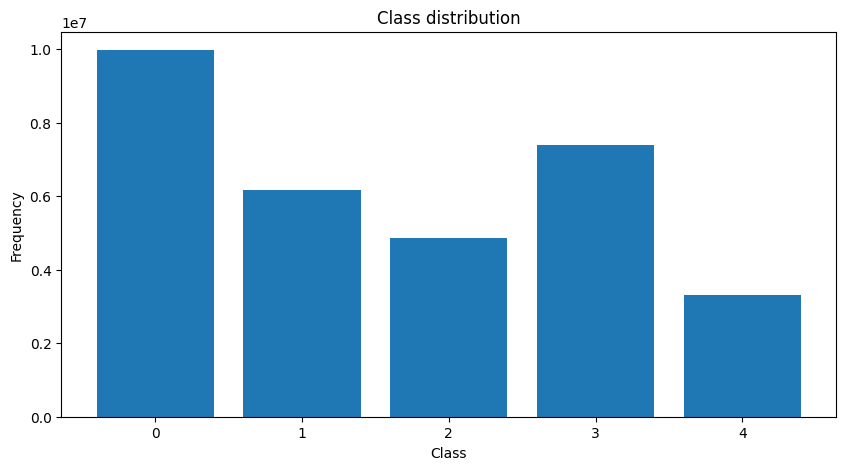

In [27]:
# Display the shapes of the combined training set
print(f"Combined training set: {X_train_combined.shape}, {y_train_combined.shape}")

# Display the distribution of classes in the combined training set
display_class_distribution(y_train_combined)

Image 2451 - Original: (64, 128, 1), 0.043137254901960784, 0.4235294117647059, float64
Image 2451 - Augmented: (64, 128, 1), 0.04313725605607033, 0.42352941632270813, float32
Image 1420 - Original: (64, 128, 1), 0.043137254901960784, 0.403921568627451, float64
Image 1420 - Augmented: (64, 128, 1), 0.05017746239900589, 0.38941314816474915, float32


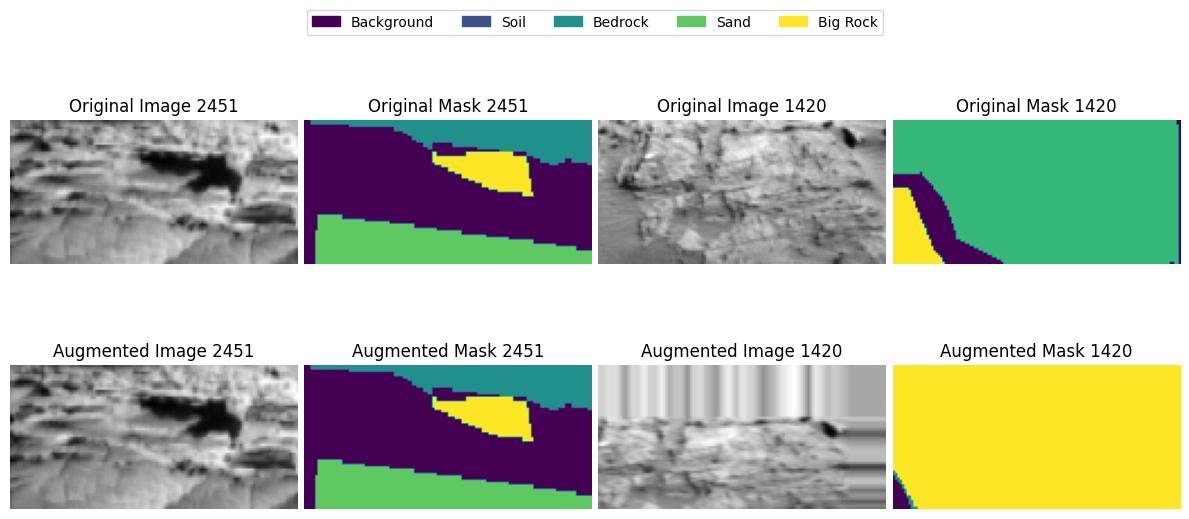

In [28]:
# Visualize augmentations
visualize_segmentation_augmentations(
    X_train_combined, y_train_combined,
    pipeline=image_mask_augmentation_pipeline,
    segmentation_classes=dataset_info['number_of_classes'],
    epoch=0,
)

## 🧮 Define Network Parameters

In [29]:
# Number of training epochs
epochs = 500

# Batch size for training
batch_size = 64

# Learning rate: step size for updating the model's weights
learning_rate = 0.001

### 💽 Dataset Creation

In [30]:
print(f"Combined training set: {X_train_combined.shape}, {y_train_combined.shape}")
print(f"Training set: {X_train.shape}, {y_train.shape}")

Combined training set: (3868, 64, 128, 1), (3868, 64, 128)
Training set: (2004, 64, 128, 1), (2004, 64, 128)


In [31]:
# Convert the data types of the original dataset to match those of the augmented dataset
X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.int32)
X_train_combined = X_train_combined.astype(np.float32)
y_train_combined = y_train_combined.astype(np.int32)
X_val = X_val.astype(np.float32)
y_val = y_val.astype(np.int32)

# train_dataset = tf.data.Dataset.from_tensor_slices((X_train_combined, y_train_combined))
# train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

# create an augmentation dataset
train_aug_dataset = tf.data.Dataset.from_tensor_slices((X_train_combined, y_train_combined))
train_aug_dataset = train_aug_dataset.shuffle(buffer_size=1024).batch(batch_size)

# apply augmentation to the dataset using the augmentation pipeline
# all the training samples will be augmented
train_aug_dataset = train_aug_dataset.map(
    lambda x, y: augment_segmentation_data(
        x, y, image_mask_augmentation_pipeline, dataset_info['number_of_classes'], epoch=epochs
    ),
    num_parallel_calls=tf.data.AUTOTUNE
)

# merge the augmented dataset with the original one
# train_dataset = train_dataset.concatenate(train_aug_dataset)
train_dataset = train_aug_dataset

# Shuffle the training set
train_dataset = train_dataset.shuffle(buffer_size=1024)

# Prefetch the dataset
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

In [32]:
# Validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [33]:
# print training dataset shape
print(f"Training dataset: {train_dataset}")
print(f"Validation dataset: {val_dataset}")

Training dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 128, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 64, 128), dtype=tf.int32, name=None))>
Validation dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 128, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 64, 128), dtype=tf.int32, name=None))>


## 🏋️‍♂️ Ensable model

Combine the model specialized in the Big Rock samples (see the other notebook) with the one defined on the whole dataset

In [34]:
# input shape
input_shape = X_train_combined.shape[1:]
print(f"Input shape: {input_shape}")

# number of classes
num_classes = len(np.unique(y_train_combined))
print(f"Number of classes: {num_classes}")

# Print the shapes of the training and validation sets
print(f"Training set: {X_train_combined.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")

Input shape: (64, 128, 1)
Number of classes: 5
Training set: (3868, 64, 128, 1), (2004, 64, 128)
Validation set: (501, 64, 128, 1), (501, 64, 128)


In [35]:
try:
    if is_colab:
        specialized_big_rock_model = tf.keras.models.load_model("big_rock_model.keras", compile=False)
        main_model = tf.keras.models.load_model("model_241207_111831_51.28.keras", compile=False)
    elif is_kaggle:
        specialized_big_rock_model = tf.keras.models.load_model("/kaggle/input/bigrockmodel/big_rock_model (1).keras", compile=False)  # change this with the actual kaggle path
        main_model = tf.keras.models.load_model("/kaggle/input/enhanceddualscaleunet/model_241207_111831_51.28.keras", compile=False)
    else:
        specialized_big_rock_model = tf.keras.models.load_model("../big_rock_model.keras", compile=False)
        main_model = tf.keras.models.load_model("../model_241207_111831_51.28.keras", compile=False)

    print("Models loaded succesfully!")
except Exception as e:
    print(f"Error: {e}")
    print("Error during model loading or training")

Models loaded succesfully!


In [36]:
def ensemble_mars_segmentation_model(main_model, specialized_big_rock_model, input_shape):
    # Input layer
    input_layer = tfkl.Input(shape=input_shape)
    
    # Main model prediction
    main_prediction = main_model(input_layer)
    
    # Specialized big rock model prediction
    specialized_prediction = specialized_big_rock_model(input_layer)
    
    # Weighted fusion of predictions
    ensemble_prediction = tfkl.Lambda(lambda x: 0.7 * x[0] + 0.3 * x[1])([main_prediction, specialized_prediction])
    
    ensemble_model = tf.keras.Model(inputs=input_layer, outputs=ensemble_prediction, name='EnsembleModel')
    return ensemble_model

In [37]:
ensemble_model = ensemble_mars_segmentation_model(main_model, specialized_big_rock_model, input_shape)

ensemble_model.summary()

Model: "EnsembleModel"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 128,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ EnhancedDualScaleU… │ (None, 64, 128,   │  2,600,840 │ input_layer[0][0] │
│ (Functional)        │ 5)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ UNet (Functional)   │ (None, 64, 128,   │    359,493 │ input_layer[0][0] │
│                     │ 5)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 64, 128,   │          0 │ EnhancedDualScal… │
│                     │ 5)                │            │ UNet[0][0]        │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,960,333 (11.29 MB)

 Trainable params: 2,958,029 (11.28 MB)

 Non-trainable params: 2,304 (9.00 KB)

## 🧠 Training

In [38]:
import keras
@keras.saving.register_keras_serializable()
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)

        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0

        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

In [39]:
# Compile the model
print("Compiling model...")

mean_iou = MeanIntersectionOverUnion(num_classes=num_classes, labels_to_exclude=[0], name="mean_iou")
optimizer=tf.keras.optimizers.AdamW(learning_rate=learning_rate, weight_decay=1e-6)
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False) 

ensemble_model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=['accuracy', mean_iou]
)

print("Model compiled!")

Compiling model...
Model compiled!


In [40]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_mean_iou',
    mode='max',
    patience=20,
    verbose = 1,
    restore_best_weights=True
)

reduce_lr = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

callbacks = [early_stopping, reduce_lr]

### 🚂 Train the Model

In [41]:
# Training
history = ensemble_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks = callbacks
)

# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history.history['val_mean_iou'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

Epoch 1/500


W0000 00:00:1733928112.332738     172 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

36/61 ━━━━━━━━━━━━━━━━━━━━ 14s 598ms/step - accuracy: 0.7108 - loss: 0.8145 - mean_iou: 0.5280

W0000 00:00:1733928213.201021      98 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7064 - loss: 0.8212 - mean_iou: 0.5245

W0000 00:00:1733928276.040828      99 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1733928283.727623      97 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


61/61 ━━━━━━━━━━━━━━━━━━━━ 209s 2s/step - accuracy: 0.7063 - loss: 0.8212 - mean_iou: 0.5245 - val_accuracy: 0.7402 - val_loss: 0.7367 - val_mean_iou: 0.4498 - learning_rate: 0.0010
Epoch 2/500


W0000 00:00:1733928296.917243     228 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

61/61 ━━━━━━━━━━━━━━━━━━━━ 45s 637ms/step - accuracy: 0.7085 - loss: 0.8043 - mean_iou: 0.5299 - val_accuracy: 0.7267 - val_loss: 0.7624 - val_mean_iou: 0.4788 - learning_rate: 0.0010
Epoch 3/500


W0000 00:00:1733928341.717054     241 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

61/61 ━━━━━━━━━━━━━━━━━━━━ 46s 645ms/step - accuracy: 0.7072 - loss: 0.8067 - mean_iou: 0.5339 - val_accuracy: 0.7427 - val_loss: 0.7534 - val_mean_iou: 0.4729 - learning_rate: 0.0010
Epoch 4/500


W0000 00:00:1733928387.401334     254 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

61/61 ━━━━━━━━━━━━━━━━━━━━ 46s 661ms/step - accuracy: 0.7254 - loss: 0.7730 - mean_iou: 0.5435 - val_accuracy: 0.5472 - val_loss: 1.0859 - val_mean_iou: 0.2948 - learning_rate: 0.0010
Epoch 5/500


W0000 00:00:1733928433.723093     267 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

61/61 ━━━━━━━━━━━━━━━━━━━━ 47s 678ms/step - accuracy: 0.7319 - loss: 0.7511 - mean_iou: 0.5636 - val_accuracy: 0.7333 - val_loss: 0.7533 - val_mean_iou: 0.4871 - learning_rate: 0.0010
Epoch 6/500


W0000 00:00:1733928481.078545     280 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 675ms/step - accuracy: 0.7268 - loss: 0.7685 - mean_iou: 0.5404
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
61/61 ━━━━━━━━━━━━━━━━━━━━ 49s 703ms/step - accuracy: 0.7267 - loss: 0.7685 - mean_iou: 0.5404 - val_accuracy: 0.7328 - val_loss: 0.7479 - val_mean_iou: 0.4463 - learning_rate: 0.0010
Epoch 7/500


W0000 00:00:1733928529.752236     293 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

61/61 ━━━━━━━━━━━━━━━━━━━━ 49s 707ms/step - accuracy: 0.7419 - loss: 0.7240 - mean_iou: 0.5684 - val_accuracy: 0.7614 - val_loss: 0.6650 - val_mean_iou: 0.5086 - learning_rate: 1.0000e-04
Epoch 8/500


W0000 00:00:1733928579.099171     305 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

61/61 ━━━━━━━━━━━━━━━━━━━━ 49s 710ms/step - accuracy: 0.7612 - loss: 0.6883 - mean_iou: 0.5832 - val_accuracy: 0.7698 - val_loss: 0.6551 - val_mean_iou: 0.5166 - learning_rate: 1.0000e-04
Epoch 9/500


W0000 00:00:1733928628.182420     319 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

61/61 ━━━━━━━━━━━━━━━━━━━━ 49s 709ms/step - accuracy: 0.7503 - loss: 0.6939 - mean_iou: 0.5813 - val_accuracy: 0.7619 - val_loss: 0.6614 - val_mean_iou: 0.5077 - learning_rate: 1.0000e-04
Epoch 10/500


W0000 00:00:1733928677.561494     332 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

61/61 ━━━━━━━━━━━━━━━━━━━━ 49s 708ms/step - accuracy: 0.7475 - loss: 0.7001 - mean_iou: 0.5849 - val_accuracy: 0.7632 - val_loss: 0.6613 - val_mean_iou: 0.5109 - learning_rate: 1.0000e-04
Epoch 11/500


W0000 00:00:1733928726.523220     345 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

61/61 ━━━━━━━━━━━━━━━━━━━━ 49s 711ms/step - accuracy: 0.7553 - loss: 0.6863 - mean_iou: 0.5897 - val_accuracy: 0.7669 - val_loss: 0.6553 - val_mean_iou: 0.5133 - learning_rate: 1.0000e-04
Epoch 12/500


W0000 00:00:1733928775.840287     358 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

61/61 ━━━━━━━━━━━━━━━━━━━━ 49s 709ms/step - accuracy: 0.7595 - loss: 0.6765 - mean_iou: 0.5957 - val_accuracy: 0.7664 - val_loss: 0.6535 - val_mean_iou: 0.5068 - learning_rate: 1.0000e-04
Epoch 13/500


W0000 00:00:1733928825.058507     370 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

61/61 ━━━━━━━━━━━━━━━━━━━━ 49s 708ms/step - accuracy: 0.7699 - loss: 0.6666 - mean_iou: 0.5980 - val_accuracy: 0.7683 - val_loss: 0.6509 - val_mean_iou: 0.5065 - learning_rate: 1.0000e-04
Epoch 14/500


W0000 00:00:1733928874.169594     383 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

61/61 ━━━━━━━━━━━━━━━━━━━━ 49s 708ms/step - accuracy: 0.7634 - loss: 0.6718 - mean_iou: 0.5945 - val_accuracy: 0.7633 - val_loss: 0.6597 - val_mean_iou: 0.4961 - learning_rate: 1.0000e-04
Epoch 15/500


W0000 00:00:1733928923.144774     397 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

61/61 ━━━━━━━━━━━━━━━━━━━━ 49s 708ms/step - accuracy: 0.7637 - loss: 0.6629 - mean_iou: 0.5932 - val_accuracy: 0.7713 - val_loss: 0.6425 - val_mean_iou: 0.5117 - learning_rate: 1.0000e-04
Epoch 16/500


W0000 00:00:1733928971.972015     409 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

61/61 ━━━━━━━━━━━━━━━━━━━━ 50s 712ms/step - accuracy: 0.7672 - loss: 0.6651 - mean_iou: 0.6042 - val_accuracy: 0.7666 - val_loss: 0.6482 - val_mean_iou: 0.5105 - learning_rate: 1.0000e-04
Epoch 17/500


W0000 00:00:1733929021.509683     423 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

61/61 ━━━━━━━━━━━━━━━━━━━━ 49s 708ms/step - accuracy: 0.7623 - loss: 0.6694 - mean_iou: 0.5929 - val_accuracy: 0.7683 - val_loss: 0.6501 - val_mean_iou: 0.5165 - learning_rate: 1.0000e-04
Epoch 18/500


W0000 00:00:1733929070.784779     435 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

61/61 ━━━━━━━━━━━━━━━━━━━━ 50s 713ms/step - accuracy: 0.7776 - loss: 0.6440 - mean_iou: 0.6025 - val_accuracy: 0.7709 - val_loss: 0.6330 - val_mean_iou: 0.5101 - learning_rate: 1.0000e-04
Epoch 19/500


W0000 00:00:1733929120.538586     448 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

61/61 ━━━━━━━━━━━━━━━━━━━━ 49s 708ms/step - accuracy: 0.7675 - loss: 0.6680 - mean_iou: 0.5892 - val_accuracy: 0.7786 - val_loss: 0.6410 - val_mean_iou: 0.5272 - learning_rate: 1.0000e-04
Epoch 20/500


W0000 00:00:1733929169.585475     462 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

61/61 ━━━━━━━━━━━━━━━━━━━━ 49s 709ms/step - accuracy: 0.7719 - loss: 0.6553 - mean_iou: 0.5964 - val_accuracy: 0.7655 - val_loss: 0.6465 - val_mean_iou: 0.5238 - learning_rate: 1.0000e-04
Epoch 21/500


W0000 00:00:1733929218.689477     475 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

61/61 ━━━━━━━━━━━━━━━━━━━━ 49s 709ms/step - accuracy: 0.7696 - loss: 0.6483 - mean_iou: 0.6074 - val_accuracy: 0.7750 - val_loss: 0.6353 - val_mean_iou: 0.5232 - learning_rate: 1.0000e-04
Epoch 22/500


W0000 00:00:1733929267.687409     488 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

61/61 ━━━━━━━━━━━━━━━━━━━━ 49s 709ms/step - accuracy: 0.7665 - loss: 0.6600 - mean_iou: 0.6009 - val_accuracy: 0.7722 - val_loss: 0.6400 - val_mean_iou: 0.5065 - learning_rate: 1.0000e-04
Epoch 23/500


W0000 00:00:1733929316.716576     500 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 679ms/step - accuracy: 0.7734 - loss: 0.6510 - mean_iou: 0.5997
Epoch 23: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
61/61 ━━━━━━━━━━━━━━━━━━━━ 49s 707ms/step - accuracy: 0.7733 - loss: 0.6510 - mean_iou: 0.5997 - val_accuracy: 0.7660 - val_loss: 0.6453 - val_mean_iou: 0.5105 - learning_rate: 1.0000e-04
Epoch 24/500


W0000 00:00:1733929365.891788     514 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

61/61 ━━━━━━━━━━━━━━━━━━━━ 49s 706ms/step - accuracy: 0.7771 - loss: 0.6388 - mean_iou: 0.6095 - val_accuracy: 0.7720 - val_loss: 0.6332 - val_mean_iou: 0.5127 - learning_rate: 1.0000e-05
Epoch 25/500


W0000 00:00:1733929414.925928     527 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

61/61 ━━━━━━━━━━━━━━━━━━━━ 48s 689ms/step - accuracy: 0.7721 - loss: 0.6470 - mean_iou: 0.6030 - val_accuracy: 0.7729 - val_loss: 0.6318 - val_mean_iou: 0.5129 - learning_rate: 1.0000e-05
Epoch 26/500


W0000 00:00:1733929463.312609     540 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

61/61 ━━━━━━━━━━━━━━━━━━━━ 47s 682ms/step - accuracy: 0.7710 - loss: 0.6526 - mean_iou: 0.5948 - val_accuracy: 0.7725 - val_loss: 0.6315 - val_mean_iou: 0.5116 - learning_rate: 1.0000e-05
Epoch 27/500


W0000 00:00:1733929510.778307     552 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

61/61 ━━━━━━━━━━━━━━━━━━━━ 47s 676ms/step - accuracy: 0.7756 - loss: 0.6408 - mean_iou: 0.6045 - val_accuracy: 0.7743 - val_loss: 0.6311 - val_mean_iou: 0.5149 - learning_rate: 1.0000e-05
Epoch 28/500


W0000 00:00:1733929558.258132     565 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

61/61 ━━━━━━━━━━━━━━━━━━━━ 47s 672ms/step - accuracy: 0.7716 - loss: 0.6430 - mean_iou: 0.6043 - val_accuracy: 0.7737 - val_loss: 0.6307 - val_mean_iou: 0.5160 - learning_rate: 1.0000e-05
Epoch 29/500


W0000 00:00:1733929605.111421     584 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

61/61 ━━━━━━━━━━━━━━━━━━━━ 47s 669ms/step - accuracy: 0.7720 - loss: 0.6507 - mean_iou: 0.5986 - val_accuracy: 0.7735 - val_loss: 0.6319 - val_mean_iou: 0.5160 - learning_rate: 1.0000e-05
Epoch 30/500


W0000 00:00:1733929652.124269     597 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

61/61 ━━━━━━━━━━━━━━━━━━━━ 47s 667ms/step - accuracy: 0.7842 - loss: 0.6289 - mean_iou: 0.6095 - val_accuracy: 0.7747 - val_loss: 0.6301 - val_mean_iou: 0.5164 - learning_rate: 1.0000e-05
Epoch 31/500


W0000 00:00:1733929698.721029     610 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

61/61 ━━━━━━━━━━━━━━━━━━━━ 47s 667ms/step - accuracy: 0.7755 - loss: 0.6391 - mean_iou: 0.6113 - val_accuracy: 0.7725 - val_loss: 0.6339 - val_mean_iou: 0.5083 - learning_rate: 1.0000e-05
Epoch 32/500


W0000 00:00:1733929745.600182     623 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

61/61 ━━━━━━━━━━━━━━━━━━━━ 46s 667ms/step - accuracy: 0.7665 - loss: 0.6512 - mean_iou: 0.6030 - val_accuracy: 0.7715 - val_loss: 0.6336 - val_mean_iou: 0.5059 - learning_rate: 1.0000e-05
Epoch 33/500


W0000 00:00:1733929792.095041     637 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

61/61 ━━━━━━━━━━━━━━━━━━━━ 47s 667ms/step - accuracy: 0.7685 - loss: 0.6581 - mean_iou: 0.5939 - val_accuracy: 0.7735 - val_loss: 0.6313 - val_mean_iou: 0.5096 - learning_rate: 1.0000e-05
Epoch 34/500


W0000 00:00:1733929838.694522     650 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

61/61 ━━━━━━━━━━━━━━━━━━━━ 47s 668ms/step - accuracy: 0.7713 - loss: 0.6495 - mean_iou: 0.6031 - val_accuracy: 0.7724 - val_loss: 0.6331 - val_mean_iou: 0.5067 - learning_rate: 1.0000e-05
Epoch 35/500


W0000 00:00:1733929885.276700     662 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 642ms/step - accuracy: 0.7693 - loss: 0.6517 - mean_iou: 0.6098
Epoch 35: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
61/61 ━━━━━━━━━━━━━━━━━━━━ 47s 669ms/step - accuracy: 0.7694 - loss: 0.6515 - mean_iou: 0.6098 - val_accuracy: 0.7692 - val_loss: 0.6382 - val_mean_iou: 0.5058 - learning_rate: 1.0000e-05
Epoch 36/500


W0000 00:00:1733929931.993967     676 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

61/61 ━━━━━━━━━━━━━━━━━━━━ 47s 670ms/step - accuracy: 0.7828 - loss: 0.6381 - mean_iou: 0.6033 - val_accuracy: 0.7704 - val_loss: 0.6358 - val_mean_iou: 0.5067 - learning_rate: 1.0000e-06
Epoch 37/500


W0000 00:00:1733929978.723849     689 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

61/61 ━━━━━━━━━━━━━━━━━━━━ 47s 671ms/step - accuracy: 0.7685 - loss: 0.6499 - mean_iou: 0.6022 - val_accuracy: 0.7712 - val_loss: 0.6345 - val_mean_iou: 0.5088 - learning_rate: 1.0000e-06
Epoch 38/500


W0000 00:00:1733930025.505437     702 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

61/61 ━━━━━━━━━━━━━━━━━━━━ 47s 669ms/step - accuracy: 0.7778 - loss: 0.6299 - mean_iou: 0.6101 - val_accuracy: 0.7712 - val_loss: 0.6345 - val_mean_iou: 0.5087 - learning_rate: 1.0000e-06
Epoch 39/500


W0000 00:00:1733930072.030598     715 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "nearest" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 64 } dim { size: 128 } dim { size: 2 } } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -8 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "@\000\000\000\200\000\000\000" } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2000 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 40370176 memory_size: 268435456 } outputs { dtype: DT_FLOAT sh

61/61 ━━━━━━━━━━━━━━━━━━━━ 47s 669ms/step - accuracy: 0.7736 - loss: 0.6477 - mean_iou: 0.6044 - val_accuracy: 0.7711 - val_loss: 0.6349 - val_mean_iou: 0.5079 - learning_rate: 1.0000e-06
Epoch 39: early stopping
Restoring model weights from the end of the best epoch: 19.
Final validation Mean Intersection Over Union: 52.72%


### 📦 Save the Model

In [42]:
# Save the model
model_filename = f'{model_filename}.keras'
print(f"Saving model to: {model_filename}")
ensemble_model.save(model_filename)

Saving model to: model_241211_144036.keras


## 📈 Training and Validation Graphs

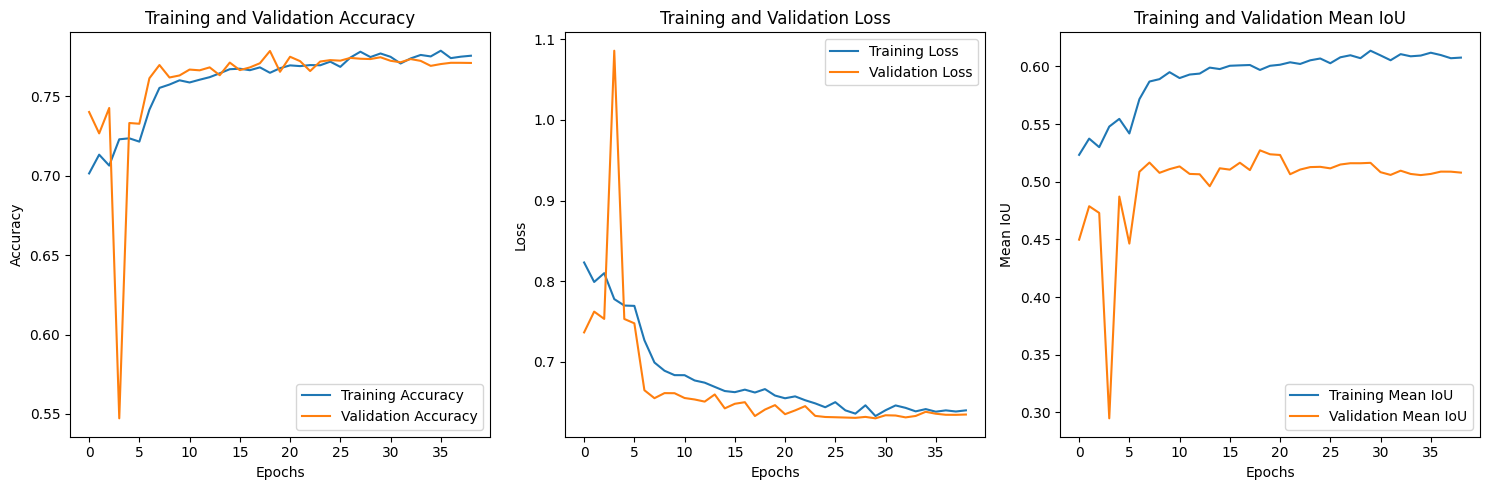

In [43]:
# Plot training & validation accuracy, loss, and IoU
def plot_metrics(history):
    metrics = ['accuracy', 'loss', 'mean_iou']
    titles = ['Accuracy', 'Loss', 'Mean IoU']

    plt.figure(figsize=(15, 5))

    for i, metric in enumerate(metrics):
        plt.subplot(1, 3, i+1)
        plt.plot(history.history[metric], label=f'Training {titles[i]}')
        plt.plot(history.history[f'val_{metric}'], label=f'Validation {titles[i]}')
        plt.title(f'Training and Validation {titles[i]}')
        plt.xlabel('Epochs')
        plt.ylabel(titles[i])
        plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function to plot the metrics
plot_metrics(history)

## 📋 Predictions

In [44]:
# Load the best model
# model = tfk.models.load_model(model_filename)
model = ensemble_model

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


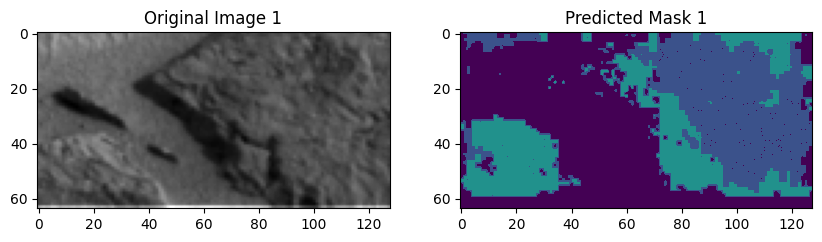

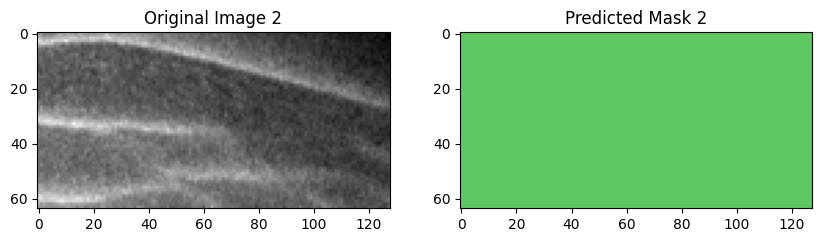

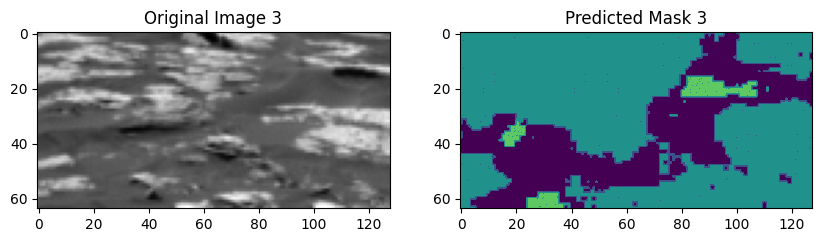

In [45]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming X_test is already loaded and preprocessed (normalized, with added color channel if necessary)
# If not, load and preprocess it as you did for X_train and X_val

# Predict masks for the first 3 images in X_test
predictions = model.predict(X_test[:3])

# Get the class with the highest probability for each pixel
predicted_masks = np.argmax(predictions, axis=-1)

# Display the predictions
for i in range(3):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(X_test[i].squeeze(), cmap='gray')  # Display the original image
    plt.title(f"Original Image {i+1}")

    plt.subplot(1, 2, 2)
    plt.imshow(predicted_masks[i], cmap=cmap, norm=norm)  # Display the predicted mask
    plt.title(f"Predicted Mask {i+1}")

    plt.show()

## 🔬 Inference

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


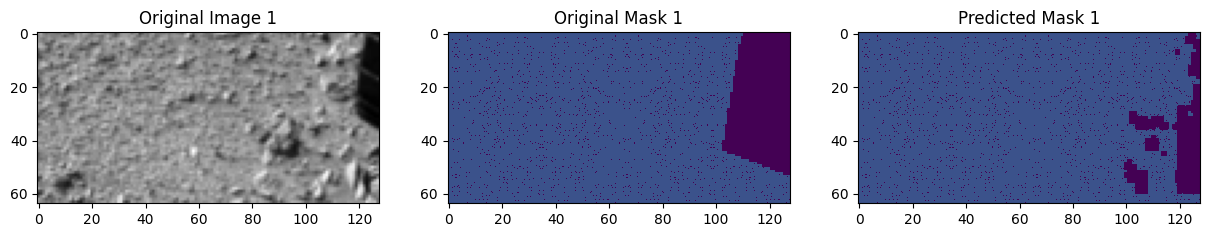

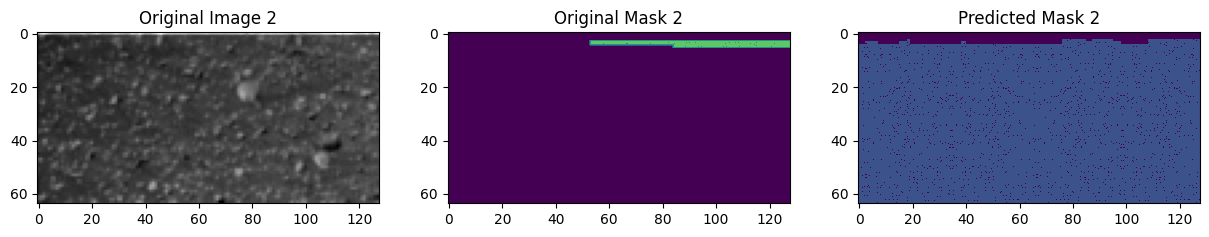

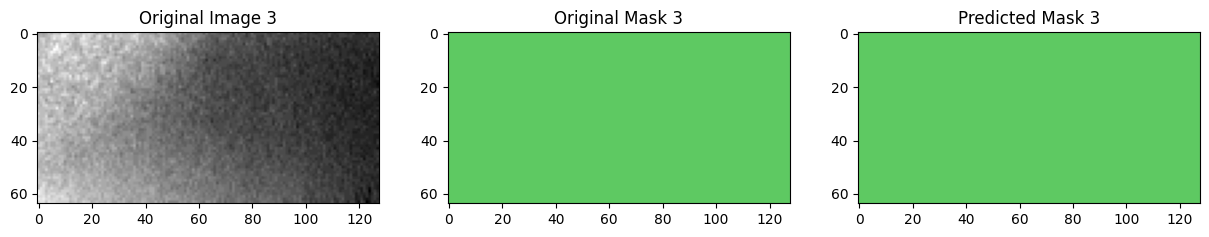

In [46]:
import matplotlib.pyplot as plt

predictions = model.predict(X_train[:3])
predicted_masks = np.argmax(predictions, axis=-1)

# Display the predictions
for i in range(3):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(X_train[i].squeeze(), cmap='gray')  # Display the original image
    plt.title(f"Original Image {i+1}")

    plt.subplot(1, 3, 2)
    plt.imshow(y_train[i], cmap=cmap, norm=norm)  # Display the original mask
    plt.title(f"Original Mask {i+1}")

    plt.subplot(1, 3, 3)
    plt.imshow(predicted_masks[i], cmap=cmap, norm=norm)  # Display the predicted mask
    plt.title(f"Predicted Mask {i+1}")

    plt.show()

In [47]:
# Mean IoU
mean_iou = tfk.metrics.MeanIoU(num_classes=num_classes)
mean_iou.update_state(y_train[:3], predicted_masks)
iou = mean_iou.result().numpy()
print(f"Mean IoU: {iou}")

# Pixel accuracy
pixel_accuracy = np.mean(y_train[:3] == predicted_masks)
print(f"Pixel accuracy: {pixel_accuracy}")

Mean IoU: 0.4992661476135254
Pixel accuracy: 0.646484375


In [48]:
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score

def evaluate_per_class(y_true, y_pred, num_classes=5):
    """
    Compute precision, recall, F1-score e IoU for each class.
    """
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()

    metrics = {
        "Class": [],
        "Precision": [],
        "Recall": [],
        "F1-Score": [],
        "IoU": []
    }

    for c in range(num_classes):
        class_true = (y_true_flat == c).astype(int)
        class_pred = (y_pred_flat == c).astype(int)
        
        precision = precision_score(class_true, class_pred, zero_division=0)
        recall = recall_score(class_true, class_pred, zero_division=0)
        f1 = f1_score(class_true, class_pred, zero_division=0)
        iou = jaccard_score(class_true, class_pred, zero_division=0)

        metrics["Class"].append(c)
        metrics["Precision"].append(precision)
        metrics["Recall"].append(recall)
        metrics["F1-Score"].append(f1)
        metrics["IoU"].append(iou)

    return metrics

# Prediction on the validation set
val_predictions = model.predict(X_val, verbose=0)
val_predicted_masks = np.argmax(val_predictions, axis=-1)

# Metrics
metrics = evaluate_per_class(y_val, val_predicted_masks)

# Results
import pandas as pd
metrics_df = pd.DataFrame(metrics)
print(metrics_df)

   Class  Precision    Recall  F1-Score       IoU
0      0   0.719166  0.467164  0.566400  0.395089
1      1   0.829517  0.912726  0.869135  0.768557
2      2   0.722249  0.836952  0.775382  0.633162
3      3   0.796277  0.873203  0.832968  0.713749
4      4   0.404415  0.172346  0.241693  0.137458


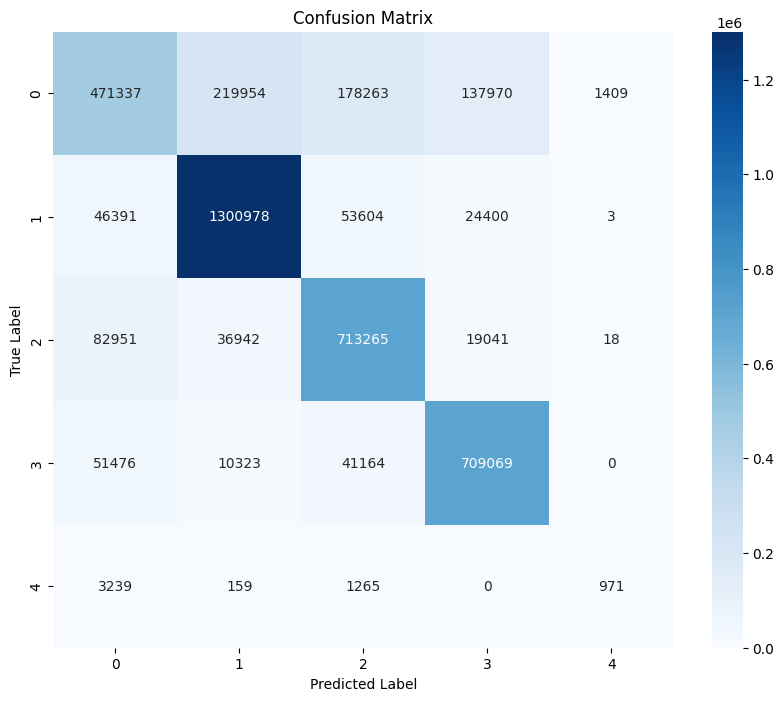

In [49]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, num_classes=5):
    """
    Plotta la matrice di confusione.
    """
    cm = confusion_matrix(y_true.flatten(), y_pred.flatten(), labels=range(num_classes))
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(num_classes), yticklabels=range(num_classes))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# Plot matrice di confusione
plot_confusion_matrix(y_val, val_predicted_masks, num_classes=5)

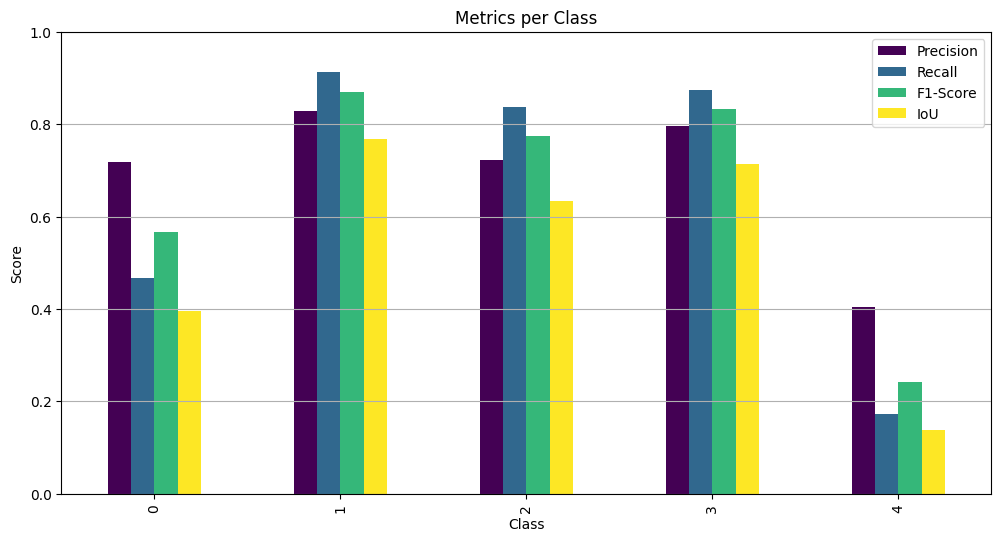

In [50]:
def plot_metrics(metrics_df):
    """
    Plotta le metriche per classe.
    """
    metrics_df.plot(
        x="Class",
        y=["Precision", "Recall", "F1-Score", "IoU"],
        kind="bar",
        figsize=(12, 6),
        colormap="viridis",
        title="Metrics per Class"
    )
    plt.xlabel("Class")
    plt.ylabel("Score")
    plt.ylim(0, 1)
    plt.grid(axis="y")
    plt.show()

# Plot delle metriche
plot_metrics(metrics_df)

---

#  

<img src="https://airlab.deib.polimi.it/wp-content/uploads/2019/07/airlab-logo-new_cropped.png" width="350">



<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/95/Instagram_logo_2022.svg/800px-Instagram_logo_2022.svg.png" width="15"> **Instagram:** https://www.instagram.com/airlab_polimi/



<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/81/LinkedIn_icon.svg/2048px-LinkedIn_icon.svg.png" width="15"> **LinkedIn:** https://www.linkedin.com/company/airlab-polimi/

___

Credits: Alberto Archetti 📧 alberto.archetti@polito.it











```

   Copyright 2024 Alberto Archetti



   Licensed under the Apache License, Version 2.0 (the "License");

   you may not use this file except in compliance with the License.

   You may obtain a copy of the License at



       http://www.apache.org/licenses/LICENSE-2.0



   Unless required by applicable law or agreed to in writing, software

   distributed under the License is distributed on an "AS IS" BASIS,

   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.

   See the License for the specific language governing permissions and

   limitations under the License.

```